# Project - Modeling Complex Genomic Associations


### Import Necessary Python Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

### Load one of the datasets 

In [2]:
# Load tab-delimited text file into a DataFrame
df = pd.read_csv('Data/Small_Datasets/4-wayAdditive_100feat.txt', delimiter='\t')

# Display the first few rows of the DataFrame
print("First few rows of the DataFrame:")
df.head()
df.shape

First few rows of the DataFrame:


(1000, 101)

## Basic Exploratory Analysis

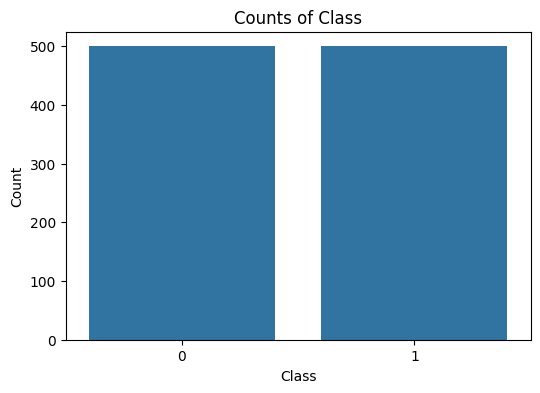

In [3]:
# Choose the column for which you want to plot the counts
column_name = 'Class'

# Get the value counts for the specified column
value_counts = df[column_name].value_counts()

# Plot the value counts using seaborn
plt.figure(figsize=(6, 4))
sns.barplot(x=value_counts.index, y=value_counts.values)
plt.title(f'Counts of {column_name}')
plt.xlabel(column_name)
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [4]:
# Get summary statistics of numeric columns
print("\nSummary statistics of numeric columns:")
print(df.describe())


Summary statistics of numeric columns:
               N0           N1           N2           N3           N4  \
count  1000.00000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.31600     0.580000     0.936000     0.496000     0.865000   
std       0.52385     0.644993     0.708806     0.605269     0.693726   
min       0.00000     0.000000     0.000000     0.000000     0.000000   
25%       0.00000     0.000000     0.000000     0.000000     0.000000   
50%       0.00000     0.000000     1.000000     0.000000     1.000000   
75%       1.00000     1.000000     1.000000     1.000000     1.000000   
max       2.00000     2.000000     2.000000     2.000000     2.000000   

                N5           N6          N7           N8           N9  ...  \
count  1000.000000  1000.000000  1000.00000  1000.000000  1000.000000  ...   
mean      0.197000     0.222000     0.54400     0.702000     0.581000  ...   
std       0.407869     0.430001     0.63755     0.685322     0.63862

In [5]:
# Missing Value Assessment

# Group the DataFrame by the "class" column
grouped_df = df.groupby('Class')

# Calculate the sum of missing values in rows within each group
missing_values_per_class = grouped_df.apply(lambda x: x.isnull().sum().sum())

# Now 'missing_values_per_class' contains the sum of missing values for each class
print("Sum of missing values for each class:")
print(missing_values_per_class)

# Count missing values in dataset
total_missing_values = df.isna().sum().sum()

# Now 'total_missing_values' contains the total number of missing values in the DataFrame
print("Total number of missing values:", total_missing_values)

Sum of missing values for each class:
Class
0    0
1    0
dtype: int64
Total number of missing values: 0


C:\Users\Sourabh Samanta\AppData\Local\Temp\ipykernel_4996\521584815.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_values_per_class = grouped_df.apply(lambda x: x.isnull().sum().sum())


### Train and Evaluate Decision Tree Models (with 3-fold CV)

In [6]:
def train_model(model):
    # Split data into features and target
    X = df.drop(columns=['Class'])
    y = df['Class']

    # Initialize evaluation metrics lists
    accuracies = []
    balanced_accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    # Initialize KFold cross-validation
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    
    # Initialize lists to store true labels and predicted probabilities
    true_labels = []
    predicted_probabilities = []

    # Iterate over each fold of cross-validation
    for train_index, test_index in kf.split(X):
        # Split data into train and test sets for this fold
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)

        # Predict on the testing data
        y_pred = model.predict(X_test)

        # Get predicted probabilities for the positive class
        y_probs = model.predict_proba(X_test)[:, 1]

        # Calculate evaluation metrics
        accuracies.append(accuracy_score(y_test, y_pred))
        balanced_accuracies.append(balanced_accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
        
        # Append true labels and predicted probabilities
        true_labels.extend(y_test)
        predicted_probabilities.extend(y_probs)

    # Calculate average evaluation metrics
    avg_accuracy = sum(accuracies) / len(accuracies)
    avg_balanced_accuracy = sum(balanced_accuracies) / len(balanced_accuracies)
    avg_precision = sum(precisions) / len(precisions)
    avg_recall = sum(recalls) / len(recalls)
    avg_f1 = sum(f1_scores) / len(f1_scores)

    # Print summary of model performance
    print("Average Accuracy:", avg_accuracy)
    print("Average Balanced Accuracy:", avg_balanced_accuracy)
    print("Average Precision:", avg_precision)
    print("Average Recall:", avg_recall)
    print("Average F1 Score:", avg_f1)

    # Compute the false positive rate (FPR), true positive rate (TPR), and thresholds
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities)

    # Calculate the area under the ROC curve (AUC)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

Average Accuracy: 0.9089988191784598
Average Balanced Accuracy: 0.9086211649543138
Average Precision: 0.9203430324949311
Average Recall: 0.8958951455996599
Average F1 Score: 0.9078822412155745


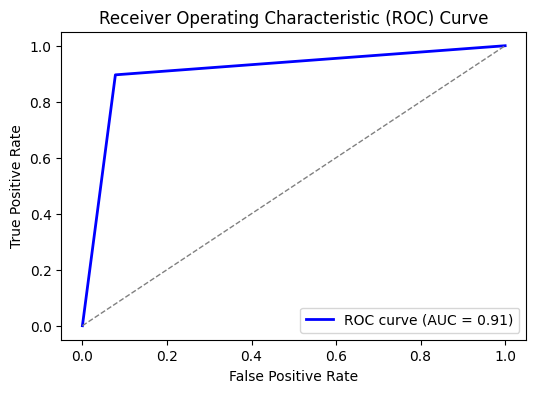

In [7]:
# Train a decision tree model
model = DecisionTreeClassifier()
train_model(model)

Average Accuracy: 0.9519999040957124
Average Balanced Accuracy: 0.9515682627946179
Average Precision: 0.9539588177464041
Average Recall: 0.9494670280662351
Average F1 Score: 0.9516495104489525


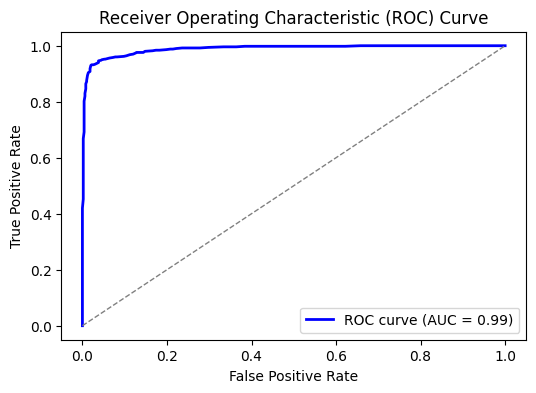

In [8]:
# Train a random forest model
model = RandomForestClassifier()
train_model(model)